### 数据读取

In [1]:
import numpy as np
from torchvision import transforms, datasets
import os
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# 检查是否有可用的 GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
# 这里没有用项目二中的数据增强标准化等方法, 是为了保持原图形状, 更好地进行展示
transform = transforms.Compose([
    transforms.RandomResizedCrop(150, scale=(0.8, 1.0)),  # 把图片的每一个channel随机裁剪成 150x150, 裁剪比例范围为 80% - 100%
    transforms.ToTensor(),             # 将图像转换为张量，并将像素值归一化到 [0, 1]
])


root_dir=r"../datasets/PetImages"

"""
datasets.ImageFolder 用于加载图像数据集, 适合用于有文件夹层级结构的分类数据集
它会自动根据文件夹结构将数据与标签（类别编号）配对
对于如下的文件夹结构：
train/
    cats/
        cat1.jpg
        cat2.jpg
    dogs/
        dog1.jpg
        dog2.jpg
        
ImageFolder 处理之后的结果为：
[
    (image1_tensor, 0),  # 对应 cats 类别
    (image2_tensor, 0),  # 对应 cats 类别
    (image3_tensor, 1),  # 对应 dogs 类别
    (image4_tensor, 1),  # 对应 dogs 类别
]
"""
# 加载训练集数据，应用 transforms
train_data = datasets.ImageFolder(
    os.path.join(root_dir, 'train'),  # 训练数据所在路径
    transform                    # 数据增强和预处理
)

# 加载测试集数据，应用 transforms
test_data = datasets.ImageFolder(
    os.path.join(root_dir, 'test'),  # 测试数据所在路径
    transform                    # 数据增强和预处理
)

train_data

Dataset ImageFolder
    Number of datapoints: 22500
    Root location: ../datasets/PetImages\train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(150, 150), scale=(0.8, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
               ToTensor()
           )

In [4]:
# 查看数据集的内容
print(f"训练集类别数量: {len(train_data.classes)}")
print(f"训练集类别名称: {train_data.classes}")
print(f"训练集数据数量: {len(train_data)}")
print(f"训练集第一个样本: {train_data[0][0].shape}, {train_data[0][1]}")  # 打印第一个样本 (image, label)

print(f"测试集类别数量: {len(test_data.classes)}")
print(f"测试集类别名称: {test_data.classes}")
print(f"测试集数据数量: {len(test_data)}")
print(f"测试集第一个样本: {test_data[0][0].shape}, {test_data[0][1]}")  # 打印第一个样本 (image, label)
# 图片形状torch.Size([3, 150, 150] : 150, 150是图片大小， 3代表三个通道(r, g, b)

训练集类别数量: 2
训练集类别名称: ['Cat', 'Dog']
训练集数据数量: 22500
训练集第一个样本: torch.Size([3, 150, 150]), 0
测试集类别数量: 2
测试集类别名称: ['Cat', 'Dog']
测试集数据数量: 2500
测试集第一个样本: torch.Size([3, 150, 150]), 0


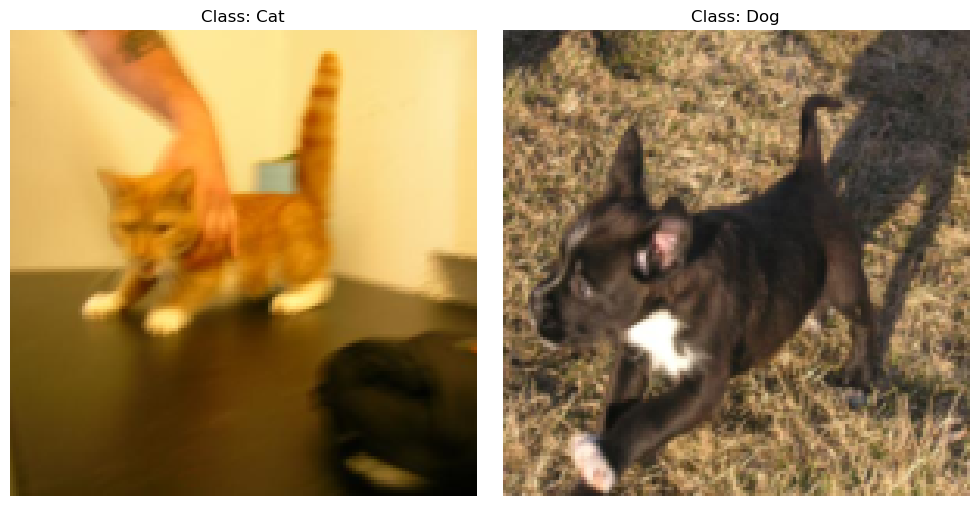

In [5]:
# 查看数据集图片

# 定义函数将 Tensor 转为 numpy 格式的图片
def imshow(img, title):
    img = img.numpy().transpose((1, 2, 0))  # 将通道维度移到最后 (H, W, C)
    img = np.clip(img, 0, 1)  # 确保像素值在 [0, 1] 范围
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')

# 获取两张不同类别的图像
def get_two_classes_samples(dataset):
    """
    高效获取数据集中每个类别的样本。
    """
    class_indices = {label: None for label in range(len(dataset.classes))}  # 存储每个类别的索引
    samples = {}  # 存储样本
    half_len = len(dataset) // 2  # 数据集一半的长度
    
    # 遍历前后索引寻找每个类别的第一个样本
    for idx in range(half_len):
        # 从前往后找
        _, label = dataset[idx]
        if class_indices[label] is None:
            class_indices[label] = idx  # 记录该类别的第一个样本索引
            samples[label] = dataset[idx][0]  # 存储对应的图片数据
        
        # 从后往前找
        _, label = dataset[len(dataset) - 1 - idx]
        if class_indices[label] is None:
            class_indices[label] = len(dataset) - 1 - idx
            samples[label] = dataset[len(dataset) - 1 - idx][0]
        
        # 如果已找到所有类别，停止搜索
        if len(samples) == len(dataset.classes):
            break

    return samples


# 从训练集获取两张不同类别的图像
class_samples = get_two_classes_samples(train_data)

# 可视化
plt.figure(figsize=(10, 5))
for i, (label, img) in enumerate(class_samples.items()):
    plt.subplot(1, 2, i+1)
    imshow(img, f"Class: {train_data.classes[label]}")
plt.tight_layout()
plt.show()

In [6]:
batch_size=32

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_data, batch_size=batch_size)

### 模型构建

`nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)`

卷积层输出计算公式：
$N = (W - F + 2P) / S + 1$
其中，
- N：输出大小
- W：输入大小
- F：卷积核大小
- P：填充值大小
- S：步长大小

In [7]:
class Net(torch.nn.Module):
    def __init__(self):
        # 输入形状: (batch, 3, 150, 150)
        super(Net, self).__init__()

        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),  # 输出: (batch, 32, 150, 150)
            torch.nn.BatchNorm2d(32),  # 增加 Batch Normalization 提高训练稳定性
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)  # 输出: (batch, 32, 75, 75)
        )

        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # 输出: (batch, 64, 75, 75)
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)  # 输出: (batch, 64, 37, 37)
        )

        self.conv3 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # 输出: (batch, 128, 37, 37)
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)  # 输出: (batch, 128, 18, 18)
        )
        self.conv4 = torch.nn.Sequential(
            torch.nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),  # 输出: (batch, 256, 18, 18)
            torch.nn.BatchNorm2d(256),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)  # 输出: (batch, 256, 9, 9)
        )

        self.fc = torch.nn.Sequential(
            torch.nn.Linear(256 * 9 * 9, 512),  # 全连接层, 输入: 128*18*18
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),  # 添加 Dropout 防止过拟合
            torch.nn.Linear(512, 2)  # 最后输出 2 个类别
        )

    def forward(self, x):
        batch_size = x.size(0)
        x = self.conv1(x)  # 第一卷积模块
        x = self.conv2(x)  # 第二卷积模块
        x = self.conv3(x)  # 第三卷积模块
        x = self.conv4(x)  # 第四卷积模块
        x = x.view(batch_size, -1)  # 展平为全连接层输入
        x = self.fc(x)  # 全连接层
        return x  # 输出形状: (batch, 2)


In [8]:
model=Net().to(device)

lr=2e-3

# 定义损失函数和优化器
loss_fn = torch.nn.CrossEntropyLoss()  # 适用于多（二）分类问题, 适合模型输出为 (batch_size, class_num)
"""
权重衰减 (L2正则化)
在优化器中加入权重衰减，可以防止过拟合
大的权重值会导致模型对训练数据的拟合过度，从而丧失对新数据的泛化能力。
L2 正则化通过惩罚大权重值，迫使模型学到更平滑的特征分布，而不是依赖特定特征的绝对大小。
"""
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4) # 使用 Adam 优化器
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
"""
学习率衰减策略
StepLR: 每隔一定的步数衰减学习率
它会在每 step_size 个 epoch 后将学习率乘以一个因子 gamma
这种方法可以在模型训练进入瓶颈时，减少学习率，从而让优化器更精细地调整权重，避免震荡或错过局部最优
"""
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [9]:
# 查看模型结构
# 打印模型参数总数和可训练参数总数
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())  # 所有参数数量
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)  # 需要训练的参数数量
    print(f"模型总参数数量: {total_params:,}")
    print(f"模型可训练参数数量: {trainable_params:,}")

print(model)
count_parameters(model)

Net(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(

In [10]:
# 训练函数
def train(dataloader, model, loss_fn, optimizer):
    model.train()  # 设置模型为训练模式
    running_loss = 0.0
    correct = 0
    total = 0

    # 使用 tqdm 包裹数据加载器，显示进度条 (因为训练过程会比较慢)
    progress_bar = tqdm(dataloader, desc="Training", leave=False)
    for images, labels in progress_bar:
        # 将数据移动到设备
        images, labels = images.to(device), labels.to(device)

        # 前向传播
        outputs = model(images)
        loss = loss_fn(outputs, labels)

        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()  # 更新模型参数

        # 统计指标
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # 更新进度条描述
        progress_bar.set_postfix(loss=loss.item())
        
    scheduler.step()  # 更新学习率

    accuracy = 100 * correct / total
    avg_loss = running_loss / len(dataloader)
    return avg_loss, accuracy

In [11]:
# 测试函数
def evaluate(dataloader, model, loss_fn):
    model.eval()  # 设置模型为评估模式
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # 关闭梯度计算
        progress_bar = tqdm(dataloader, desc="Evaluating", leave=False)
        for images, labels in dataloader:
            # 将数据移动到设备
            images, labels = images.to(device), labels.to(device)

            # 前向传播
            outputs = model(images)
            loss = loss_fn(outputs, labels)

            # 统计指标
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            # 更新进度条描述
            progress_bar.set_postfix(loss=loss.item())

    accuracy = 100 * correct / total
    avg_loss = running_loss / len(dataloader)
    return avg_loss, accuracy

### 模型训练

In [12]:
# 开始训练
"""
如果不想训练太久可以适当减小epoch
epoch=10的时候训练正确率就达到了77.0%, epoch=30时才为81.0% 
再增加epoch训练效果增加不明显, 但是结果明显还未收敛。
为了更好的效果作者就增大了epoch
"""
num_epochs = 3

train_loss = []
train_acc  = []
test_loss  = []
test_acc   = []

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    
    epoch_train_loss, epoch_train_acc = train(train_loader, model, loss_fn, optimizer)

    # 在测试集上评估
    epoch_test_loss, epoch_test_acc = evaluate(test_loader, model, loss_fn)

    train_acc.append(epoch_train_acc)
    train_loss.append(epoch_train_loss)
    test_acc.append(epoch_test_acc)
    test_loss.append(epoch_test_loss)
    # 打印训练和测试结果
    template = ('Epoch:{:2d}, Train_acc:{:.1f}%, Train_loss:{:.3f}, Test_acc:{:.1f}%，Test_loss:{:.3f}')
    print(template.format(epoch+1, epoch_train_acc, epoch_train_loss, epoch_test_acc, epoch_test_loss))

print("训练完成!")

Epoch 1/3


Training:  86%|██████████████████████████████████████████████████        | 607/704 [03:23<00:35,  2.76it/s, loss=0.537]D:\develop\anaconda\envs\pytorch\lib\site-packages\PIL\TiffImagePlugin.py:900: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch: 1, Train_acc:71.2%, Train_loss:0.560, Test_acc:77.3%，Test_loss:0.479
Epoch 2/3


Epoch: 2, Train_acc:79.7%, Train_loss:0.437, Test_acc:82.7%，Test_loss:0.392
Epoch 3/3


Epoch: 3, Train_acc:83.4%, Train_loss:0.379, Test_acc:83.2%，Test_loss:0.375
训练完成!


### 结果可视化

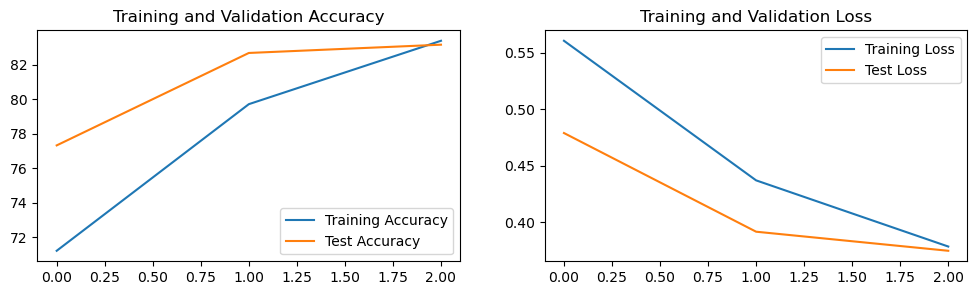

In [13]:
epochs_range = range(num_epochs)

plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1)

plt.plot(epochs_range, train_acc, label='Training Accuracy')
plt.plot(epochs_range, test_acc, label='Test Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, test_loss, label='Test Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### 模型保存

In [14]:
# 指定保存路径
save_dir = '../models/6_Adversarial_Attack'

# 确保目录存在，如果不存在则创建
import os
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# 保存模型
torch.save(model.state_dict(), os.path.join(save_dir, 'model_weights.pth'))

# # 加载模型参数
# model.load(torch.load(os.path.join(save_dir, 'model_weights.pth')))